In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/EE 641/RIFE

/content/drive/MyDrive/EE 641/RIFE


In [3]:
from model.RIFE import Model
import torch
import torch.quantization
import torch.nn as nn
from torch.nn.utils import prune
import matplotlib.pyplot as plt

In [ ]:
model = Model(local_rank=-1, arbitrary=False)
model.load_model('ckpt')

In [ ]:
model.flownet

In [ ]:
import cv2
import math
import sys
import torch
import numpy as np
import argparse
import os
import warnings
from tqdm import tqdm
import time  # Add this import at the top
import torch.cuda as cuda  # Add this import
warnings.filterwarnings('ignore')
torch.set_grad_enabled(False)
# from benchmark.utils import ssim_matlab
# from benchmark.utils.pytorch_msssim import ssim_matlab
from model.pytorch_msssim import ssim_matlab

array([[[228, 226, 222],
        [228, 226, 222],
        [229, 226, 222],
        ...,
        [237, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[232, 230, 226],
        [232, 230, 226],
        [233, 231, 227],
        ...,
        [242, 241, 241],
        [242, 241, 241],
        [242, 241, 241]],

       [[232, 230, 225],
        [232, 230, 225],
        [231, 230, 225],
        ...,
        [241, 240, 240],
        [241, 240, 240],
        [241, 240, 240]],

       ...,

       [[ 48,  56,  72],
        [ 34,  41,  58],
        [ 25,  42,  68],
        ...,
        [138, 165, 174],
        [137, 162, 170],
        [141, 166, 174]],

       [[ 41,  50,  64],
        [ 35,  44,  59],
        [ 15,  50,  73],
        ...,
        [148, 173, 181],
        [146, 169, 178],
        [146, 169, 178]],

       [[ 30,  38,  55],
        [ 35,  43,  60],
        [ 14,  61,  82],
        ...,
        [143, 168, 175],
        [139, 164, 172],
        [141, 167, 175]]], dtype=uint8)
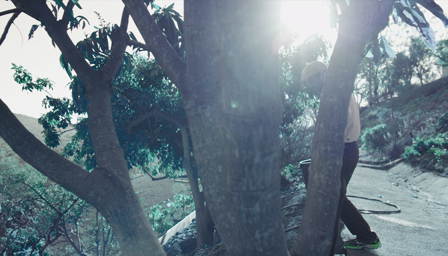

In [ ]:
cv2.imread('test' + '/im1.png')

In [ ]:
model.flownet.to('cuda')

IFNet(
  (block0): IFBlock(
    (conv0): Sequential(
      (0): Sequential(
        (0): Conv2d(6, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): PReLU(num_parameters=120)
      )
      (1): Sequential(
        (0): Conv2d(120, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
    )
    (convblock): Sequential(
      (0): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (1): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (2): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (3): Sequential(
        (0): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=240)
      )
      (4

In [ ]:
psnr_list, ssim_list, time_list, mem_list = [], [], [], []

name = 'test/'
TTA = False

# Clear CUDA cache for accurate memory measurement
cuda.empty_cache()

# Get initial memory
mem_start = cuda.memory_allocated() / (1024 ** 2)  # MB

I0 = cv2.imread(name + '/im1.png')
I1 = cv2.imread(name + '/im2.png')
I2 = cv2.imread(name + '/im3.png')
I0 = (torch.tensor(I0.transpose(2, 0, 1)).cuda() / 255.).unsqueeze(0)
I2 = (torch.tensor(I2.transpose(2, 0, 1)).cuda() / 255.).unsqueeze(0)

# Time measurement
start_time = time.time()
mid = model.inference(I0, I2)[0]
elapsed = time.time() - start_time
time_list.append(elapsed)

# Get peak memory during inference
mem_peak = cuda.max_memory_allocated() / (1024 ** 2)  # MB
mem_list.append(mem_peak - mem_start)

ssim = ssim_matlab(torch.tensor(I1.transpose(2, 0, 1)).cuda().unsqueeze(0) / 255., mid.unsqueeze(0)).detach().cpu().numpy()
mid = mid.detach().cpu().numpy().transpose(1, 2, 0)
I1 = I1 / 255.
psnr = -10 * math.log10(((I1 - mid) * (I1 - mid)).mean())
psnr_list.append(psnr)
ssim_list.append(ssim)

print(f"PSNR: {psnr:.4f} SSIM: {ssim:.4f} Time: {elapsed:.4f}s Mem: {mem_list[-1]:.2f}MB")

PSNR: 33.3196 SSIM: 0.9843 Time: 0.0158s Mem: 68.71MB


In [ ]:
len(mid)

256

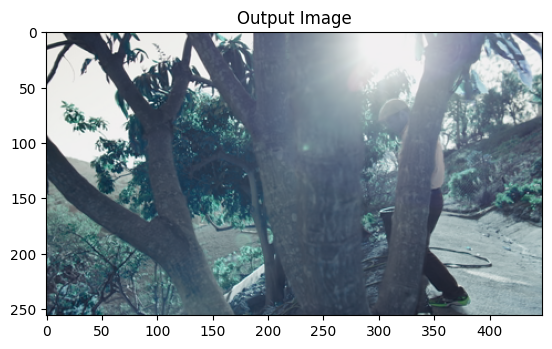

In [ ]:
# mid = mid.detach().cpu().numpy().transpose(1, 2, 0)  # Convert to NumPy array

# Display the image using matplotlib
plt.imshow(mid)
plt.title("Output Image")
plt.show()

In [ ]:
import os
import sys
import cv2
import math
import torch
import argparse
import numpy as np
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model()
model.load_model('train_log')
model.eval()
model.device()

path = 'vimeo_interp_test/'
f = open(path + 'tri_testlist.txt', 'r')
psnr_list = []
ssim_list = []
for i in f:
    name = str(i).strip()
    if(len(name) <= 1):
        continue
    print(path + 'target/' + name + '/im1.png')
    I0 = cv2.imread(path + 'target/' + name + '/im1.png')
    I1 = cv2.imread(path + 'target/' + name + '/im2.png')
    I2 = cv2.imread(path + 'target/' + name + '/im3.png')
    I0 = (torch.tensor(I0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
    I2 = (torch.tensor(I2.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
    mid = model.inference(I0, I2)[0]
    ssim = ssim_matlab(torch.tensor(I1.transpose(2, 0, 1)).to(device).unsqueeze(0) / 255., torch.round(mid * 255).unsqueeze(0) / 255.).detach().cpu().numpy()
    mid = np.round((mid * 255).detach().cpu().numpy()).astype('uint8').transpose(1, 2, 0) / 255.
    I1 = I1 / 255.
    psnr = -10 * math.log10(((I1 - mid) * (I1 - mid)).mean())
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    print("Avg PSNR: {} SSIM: {}".format(np.mean(psnr_list), np.mean(ssim_list)))


In [ ]:
mid = (mid * 255).astype(np.uint8) # Convert to 8-bit unsigned integer

# Write to PNG file
cv2.imwrite('output_image.png', mid)

True